## Installations & Imports

In [17]:
%pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/5a/5f/f4164295d6853ec6203bc728dea4da76a7145ba70482eab9e994d26e0e13/wordcloud-1.9.2-cp310-cp310-win_amd64.whl.metadata
   ---------------------------------------- 0.0/152.1 kB ? eta -:--:--
   -------- ------------------------------- 30.7/152.1 kB 1.3 MB/s eta 0:00:01
   ------------------------------------- -- 143.4/152.1 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 152.1/152.1 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
%pip install nltk

In [2]:
%pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/59/ed/548f6f686845d386a727a51a3daa411d95fc599649a2d54705f6773ac259/scikit_learn-1.3.1-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.3 MB 1.4 MB/s eta 0:00:07
   ---------------------------------------- 0.1/9.3 MB 1.3 MB/s eta 0:00:07
    --------------------------------------- 0.2/9.3 MB 1.7 MB/s eta 0:00:06
   - -------------------------------------- 0.4/9.3 MB 2.4 MB/s eta 0:00:04
   --- ------------------------------------ 0.7/9.3 MB 3.2 MB/s eta 0:00:03
   ----- ---------------------------------- 1.2/9.3 MB 4.6 MB/s eta 0:00:02
   -------- ---------------------------

In [10]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import re
import numpy as np
from wordcloud import WordCloud
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

## Accessing Titles

In [4]:
# Define the path to OAuth2 credentials JSON file
creds_path = r'C:\Users\cathe\practical-data-science-tutorial\src\data\credentials.json'

# Define the name of Google Sheet
google_sheet_name = 'Fantastic Four altmetric-data-individual'

# Define the name of the specific sheet within the Google Sheet
specific_sheet_name = 'Health and medical sciences'

# Initialize the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(creds_path, scope)
client = gspread.authorize(creds)

# Open the Google Sheet
sheet = client.open(google_sheet_name).worksheet(specific_sheet_name)

# Get a list of article names from the Google Sheet
article_names = sheet.col_values(3)[1:]  # Article names are in the third column

In [5]:
article_names[0]

'The psychological impact of quarantine and how to reduce it: rapid review of the evidence'

## Exploration of Titles

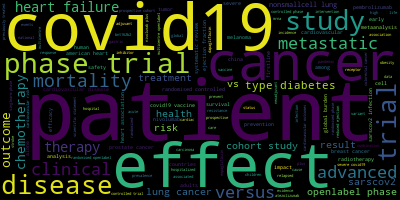

In [6]:
article_names_cleaned = np.vectorize(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))(article_names)

article_names_lower = np.vectorize(lambda x: x.lower())(article_names_cleaned)

all_titles = ','.join(list(article_names_lower))

wordcloud = WordCloud()

wordcloud.generate(all_titles)

wordcloud.to_image()

## Preprocessing Titles

In [7]:
# Download NLTK data for stopwords and lemmatisation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
# Define stopwords to remove
custom_stopwords = set(['the', 'a'])

# Initialize lemmatiser
lemmatizer = WordNetLemmatizer()

def preprocess_title(title):
    # Remove non-alphanumeric characters
    title_alpha = re.sub(r'[^a-zA-Z0-9\s]', '', title)

    # Convert to lowercase
    title_lower = title_alpha.lower()

    # Tokenize the title (break down into words)
    words = word_tokenize(title_lower)

    # Remove stopwords
    words = [word for word in words if word not in custom_stopwords]

    # Part-of-Speech (POS) tagging
    tagged_words = pos_tag(words)

    # Map POS tags to WordNet tags for lemmatisation
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None

    # Lemmatisation of verbs (converts all verbs that are the same to the infinitive) & removal of nouns
    #lemmatised_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_words if get_wordnet_pos(pos)]
    lemmatised_words = [lemmatizer.lemmatize(word, pos='v') for word, pos in tagged_words]

    # Join the words back into a processed title
    processed_title = ' '.join(lemmatised_words)

    return processed_title

# Apply preprocessing to all titles
preprocessed_titles = [preprocess_title(title) for title in article_names_lower]
preprocessed_titles[0:4]

['psychological impact of quarantine and how to reduce it rapid review of evidence',
 'global regional and national incidence prevalence and years live with disability for 354 diseases and injuries for 195 countries and territories 19902017 systematic analysis for global burden of disease study 2017',
 'novel coronavirus outbreak of global health concern',
 'covid19 and italy what next']

## Document-Term Matrix (DTM)

In [9]:
vectorizer = CountVectorizer()

# Fit and transform the preprocessed titles to create the DTM
dtm = vectorizer.fit_transform(preprocessed_titles)

# Get the feature names (terms) from the vectoriser
feature_names = vectorizer.get_feature_names_out()
dtm_array = dtm.toarray()

# Print the DTM and feature names
print("Document-Term Matrix (DTM):")
print(dtm_array)
print("Feature Names (Terms):")
print(feature_names)

Document-Term Matrix (DTM):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Feature Names (Terms):
['000' '012' '067' ... 'youth' 'zoledronic' 'zuma1']


## Latent Dirichlet Allocation (LDA)